In [1]:
import xspec

xspec.AllData.clear()
xspec.AllModels.clear()

xspec.Xset.restore("model.xcm")

xspec.Fit.statMethod = "cstat"
xspec.Fit.bayes = "on"

xspec_observation = xspec.Spectrum("spectrum_opt.pha")
xspec_observation.background = None
low_energy, high_energy = 0.3, 12.
xspec_observation.ignore(f"0.0-{low_energy:.1f} {high_energy:.1f}-**")

xspec_model = xspec.AllModels(1)
xspec_model.show()

 Solar Abundance Vector set to wilm:  Wilms, J., Allen, A. & McCray, R. ApJ 542 914 (2000) (abundances are set to zero for those elements not included in the paper).
 Cross Section Table set to vern:  Verner, Ferland, Korista, and Yakovlev 1996
Parameter delta values for fits will now be 0.01 * parValue

 The default systematic error for models is set to 0

tbvabs Version 2.3
Cosmic absorption with grains and H2, modified from
Wilms, Allen, & McCray, 2000, ApJ 542, 914-924
Questions: Joern Wilms
joern.wilms@sternwarte.uni-erlangen.de
joern.wilms@fau.de

http://pulsar.sternwarte.uni-erlangen.de/wilms/research/tbabs/

PLEASE NOTICE:
To get the model described by the above paper
you will also have to set the abundances:
   abund wilm

Note that this routine ignores the current cross section setting
as it always HAS to use the Verner cross sections as a baseline.

Model TBabs<1>(compTT<2> + powerlaw<3>) Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp


In [3]:
from bsixsa.convenience import set_prior_and_build_transform

define_prior = [
    ("TBabs", "nH", 0.01, 0.2, "uniform"),
    ("compTT", "T0", 0.05, 2.0, "uniform"),
    ("compTT", "kT", 2.1, 4.0, "uniform"),
    ("compTT", "taup", 0.5, 7, "uniform"),
    ("compTT", "norm", 0.1, 10, "loguniform"),
    ("powerlaw", "PhoIndex", 0.0, 5.0, "uniform"),
    ("powerlaw", "norm", 0.01, 10, "loguniform")
]

transformations = set_prior_and_build_transform(xspec_model, define_prior)

  uniform prior for nH between 0.010000 and 0.200000 
  uniform prior for T0 between 0.050000 and 2.000000 
  uniform prior for kT between 2.100000 and 4.000000 
  uniform prior for taup between 0.500000 and 7.000000 
  jeffreys prior for norm between 1.000000e-01 and 1.000000e+01 
  uniform prior for PhoIndex between 0.000000 and 5.000000 
  jeffreys prior for norm between 1.000000e-02 and 1.000000e+01 


In [4]:
from bsixsa import SIXSASolver

# Instantiate solver the BXA's way

solver = SIXSASolver(
    transformations,
    outputfiles_basename="sixsa_result/",
    use_background=False
)

In [5]:
import numpy as np
from bsixsa.summary_stats import merge_summary, summary_statistics_func

# Get the energy grid used by XSPEC
energy_spectrum = np.asarray(xspec.AllData(1).energies).T

# Define the summary statistics
def full_spectrum_statistics_func(spectra):
    energy_grid = np.geomspace(energy_spectrum.min(), energy_spectrum.max(), 50)
    return summary_statistics_func(spectra, energy_grid=energy_grid)

# One can add other func to compute them
summary_list = [full_spectrum_statistics_func]
embedding_func = merge_summary(*summary_list)

In [6]:
training_kwargs = dict(
    discard_prior_samples=False,
    force_first_round_loss=True,
    retrain_from_scratch=False
)

# Run the inference over 5 rounds of 5k samples
posterior = solver.run(num_rounds=5, num_simulations=5_000, training_kwargs=training_kwargs, embedding=embedding_func)

Round 1 - Folding model:   0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 73 epochs.

Round 2 - Folding model:   0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 92 epochs.

Round 3 - Folding model:   0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 68 epochs.

Round 4 - Folding model:   0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 57 epochs.

Round 5 - Folding model:   0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 21 epochs.

Computing posterior statistic - Folding model:   0%|          | 0/1000 [00:00<?, ?it/s]

   All chains are now removed.
  New chain sixsa_result/chain.fits is now loaded.
  Default chain length is now set to length of sixsa_result/chain.fits: 1000


  0%|          | 0/100 [00:00<?, ?it/s]

The error "***XSPEC Error: Requested array does not exist for this plot." can be ignored.



***XSPEC Error: Requested array does not exist for this plot.


***Warning: Fit is not current.
***Warning: Fit is not current.


/Users/sdupourque/PycharmProjects/BXA/src/bsixsa/plotting_stuff.py:185: RuntimeWarning: divide by zero encountered in divide
  residuals = (total-y_observed)/(np.percentile(total, 84, axis=0) - np.percentile(total, 16, axis=0))
/Users/sdupourque/PycharmProjects/BXA/src/bsixsa/plotting_stuff.py:185: RuntimeWarning: invalid value encountered in divide
  residuals = (total-y_observed)/(np.percentile(total, 84, axis=0) - np.percentile(total, 16, axis=0))
/Users/sdupourque/miniforge3/envs/BXA/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


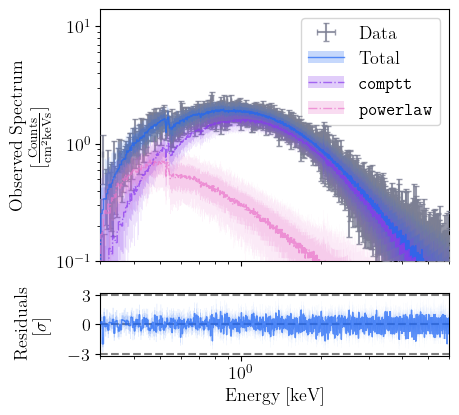

In [8]:
import matplotlib
from matplotlib import rc
from bsixsa.plotting_stuff import plot_ppc

# Activate latex text rendering
rc('font',**{'family':'serif','serif':['Computer Modern Roman'], 'size':13})
rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"

# Posterior plot
component_names = ["Total", r"\texttt{comptt}", r"\texttt{powerlaw}"]

fig = plot_ppc(solver, component_names=component_names, x_lim=(0.3, 6.), y_lim=(1e-1, 14), figsize=(4.5,4.5))
fig.savefig("ppc.pdf", bbox_inches="tight");

In [9]:
solver.posterior_dataframe()

,nH,T0,kT,taup,norm (co_1),PhoIndex,norm (po_2)
0,0.102673,0.354557,3.611355,3.343226,1.137488,1.840782,0.321389
1,0.106499,0.349582,3.290549,3.557394,1.204812,1.851279,0.392839
2,0.097823,0.351231,2.871025,3.681791,1.335791,1.642487,0.470904
3,0.110993,0.364818,2.916880,3.854206,1.368980,1.676363,0.436536
4,0.108592,0.352620,3.326934,3.704698,1.227317,2.087677,0.354468
...,...,...,...,...,...,...,...
9995,0.115507,0.339756,3.044012,3.897393,1.403894,2.078530,0.350513
9996,0.116350,0.345717,2.562859,4.149472,1.557256,1.822997,0.447183
9997,0.113339,0.353529,3.299702,3.466969,1.200704,1.863298,0.454613
9998,0.126514,0.351288,3.503278,3.621138,1.183143,2.185544,0.372809


Parameter norm (co_1) in chain BXA is not constrained


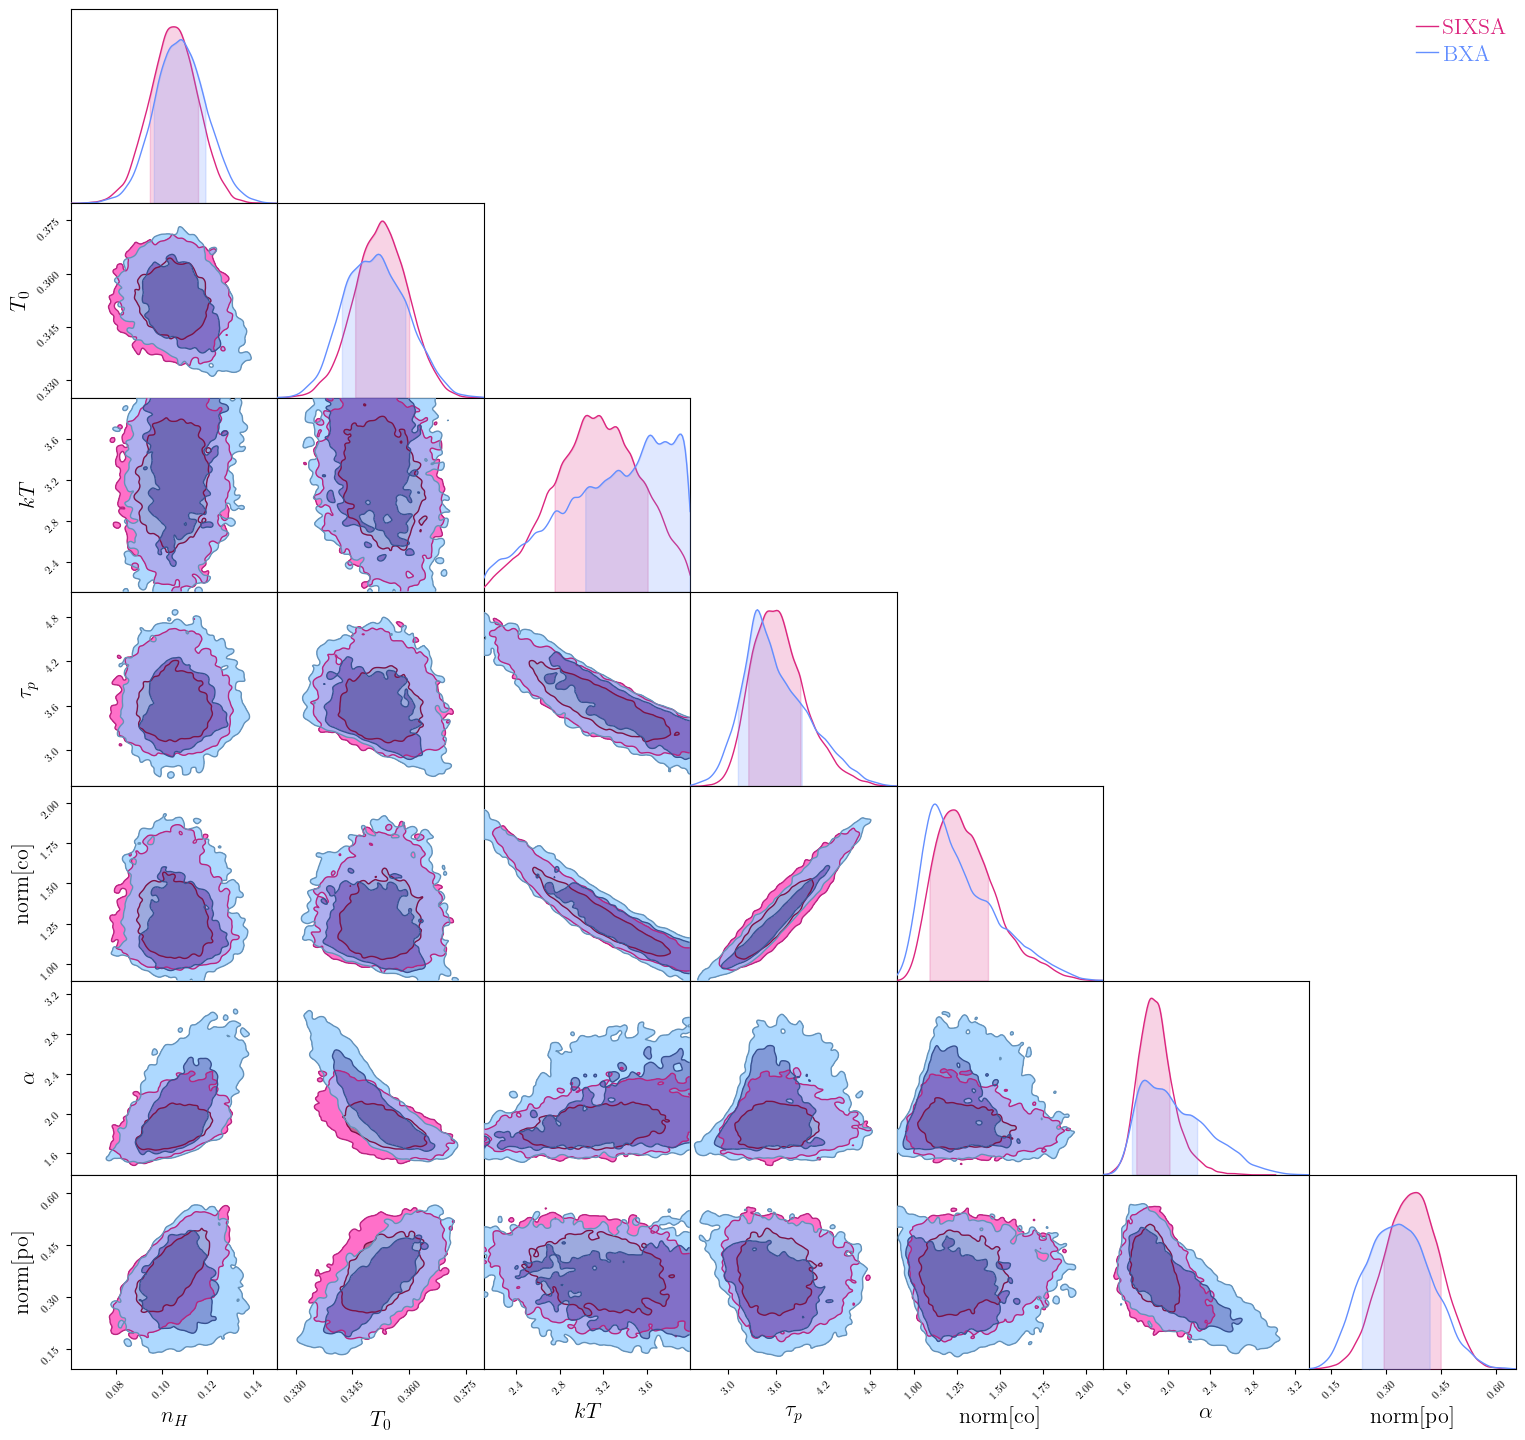

In [10]:
import pandas as pd
from chainconsumer import ChainConsumer, Chain, PlotConfig

bxa_df = pd.read_csv("bxa_dataframe.csv").drop(columns=['Unnamed: 0'])
sixsa_df = solver.posterior_dataframe()

cc = ChainConsumer()
cc.add_chain(Chain(samples=sixsa_df, name="SIXSA", color="#dc267f"))
cc.add_chain(Chain(samples=bxa_df, name="BXA", color="#648fff"))
cc.set_plot_config(
    PlotConfig(
        usetex=True,
        label_font_size=16,
        tick_font_size=8,
        serif=True,
        labels={
            'norm (co_1)':'norm[co]',
            'norm (po_2)': 'norm[po]',
            'T0': r'$T_0$',
            'taup':r'$\tau_p$',
            'kT':r'$kT$',
            'PhoIndex':r'$\alpha$',
            'nH':r'$n_H$'
        }
    )
)

cc.plotter.plot(filename="posterior.pdf");